# Parse Documents with dots.ocr

**Welcome to Modal Notebooks!**

This notebook sets you up with docs.ocr, the _state-of-the-art OCR model_
based on LLMs.

We've initialized this notebook with an **Nvidia A10 GPU**, which you can
see in the Kernel settings panel on the left sidebar. Don't worry though,
_you only pay while the notebook is running_, and it automatically shuts down
when not in use. [Check your usage](https://modal.com/settings/usage) at any point.


Modal users receive $30 in free credits per month. Let's get started.

In [24]:
!git clone https://github.com/rednote-hilab/dots.ocr.git
%cd dots.ocr

# Open repository to a specific hash.
!git checkout -q 2562ed0df4e7fdc699e4890143828014d0dada04

Cloning into 'dots.ocr'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 291 (delta 121), reused 80 (delta 80), pack-reused 136 (from 1)
Receiving objects: 100% (291/291), 36.08 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (129/129), done.
/root/dots.ocr/dots.ocr/dots.ocr/dots.ocr


First, we need to install dependencies. dots.ocr depends on a specific
version of flash-attn 2.8.0.post2, which itself requires PyTorch 2.7
or under, so we install those dependencies (~1 minute) before downloading
the model.

In [25]:
# Downgrade to PyTorch 2.7
%uv pip install torch==2.7.0 torchvision==0.22.0 torchaudio==2.7.0 --index-url https://download.pytorch.org/whl/cu126

Using Python 3.12.6 environment at: /usr/local
Audited 3 packages in 24ms
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Install prebuilt flash-attn 2.8.0.post2 to avoid slow build.
%uv pip install https://github.com/Dao-AILab/flash-attention/releases/download/v2.8.0.post2/flash_attn-2.8.0.post2+cu12torch2.7cxx11abiTRUE-cp312-cp312-linux_x86_64.whl

Using Python 3.12.6 environment at: /usr/local
Audited 1 package in 13ms
Note: you may need to restart the kernel to use updated packages.


In [27]:
%uv pip install -q -e .

Note: you may need to restart the kernel to use updated packages.


In [28]:
# Download the model (1.7B parameters) from HuggingFace.
!python tools/download_model.py

Attention: The model save dir dots.ocr should be replace by a name without `.` like DotsOCR, util we merge our code to transformers.
/usr/local/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 20 files:   0%|                                 | 0/20 [00:00<?, ?it/s]
.gitattributes: 0.00B [00:00, ?B/s]



In [29]:
%env TOKENIZERS_PARALLELISM=false

import json

import torch
from dots_ocr.utils import dict_promptmode_to_prompt
from qwen_vl_utils import process_vision_info
from transformers import AutoModelForCausalLM, AutoProcessor

# Json format

def inference(image_path: str, prompt: str, model, processor):
    messages = [
        {
            "role": "user",
            "content": [{"type": "image", "image": image_path}, {"type": "text", "text": prompt}],
        }
    ]

    # Preparation for inference
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )

    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=24000)
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    (output_text,) = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return json.loads(output_text)

env: TOKENIZERS_PARALLELISM=false


In [45]:
# Markdown format

def inference(image_path: str, prompt: str, model, processor):
    from PIL import Image
    from qwen_vl_utils import process_vision_info

    img = Image.open(image_path)

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image_path},
                {"type": "text", "text": prompt},
            ],
        }
    ]

    # prepare text + vision
    text_input = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text_input],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    with torch.inference_mode():
        generated_ids = model.generate(**inputs, max_new_tokens=24000)
    generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    # attempt load JSON else return text
    try:
        return json.loads(output_text)
    except json.JSONDecodeError:
        return output_text


In [30]:
model_path = "./weights/DotsOCR"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True, use_fast=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Run inference on the model

We're ready to download a sample image and start running OCR, using a premade prompt.

In [31]:
prompt = dict_promptmode_to_prompt["prompt_layout_all_en"]
print(prompt)

Please output the layout information from the PDF image, including each layout element's bbox, its category, and the corresponding text content within the bbox.

1. Bbox format: [x1, y1, x2, y2]

2. Layout Categories: The possible categories are ['Caption', 'Footnote', 'Formula', 'List-item', 'Page-footer', 'Page-header', 'Picture', 'Section-header', 'Table', 'Text', 'Title'].

3. Text Extraction & Formatting Rules:
    - Picture: For the 'Picture' category, the text field should be omitted.
    - Formula: Format its text as LaTeX.
    - Table: Format its text as HTML.
    - All Others (Text, Title, etc.): Format their text as Markdown.

4. Constraints:
    - The output text must be the original text from the image, with no translation.
    - All layout elements must be sorted according to human reading order.

5. Final Output: The entire output must be a single JSON object.



In [32]:
%uv pip install pdf2image

Using Python 3.12.6 environment at: /usr/local
Audited 1 package in 18ms
Note: you may need to restart the kernel to use updated packages.


In [33]:
!apt-get install -y poppler-utils




poppler-utils is already the newest version (22.12.0-2+deb12u1).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [35]:
print(dict_promptmode_to_prompt.keys())


dict_keys(['prompt_layout_all_en', 'prompt_layout_only_en', 'prompt_ocr', 'prompt_grounding_ocr'])


Converting PDF pages to images...
✅ Saved: /root/pdf_pages/page_1.jpg
✅ Saved: /root/pdf_pages/page_2.jpg
✅ Saved: /root/pdf_pages/page_3.jpg
✅ Saved: /root/pdf_pages/page_4.jpg
✅ Saved: /root/pdf_pages/page_5.jpg
✅ Saved: /root/pdf_pages/page_6.jpg
✅ Saved: /root/pdf_pages/page_7.jpg
✅ Saved: /root/pdf_pages/page_8.jpg
✅ Saved: /root/pdf_pages/page_9.jpg
✅ Saved: /root/pdf_pages/page_10.jpg
✅ Saved: /root/pdf_pages/page_11.jpg
✅ Saved: /root/pdf_pages/page_12.jpg
✅ Saved: /root/pdf_pages/page_13.jpg
✅ Saved: /root/pdf_pages/page_14.jpg
✅ Saved: /root/pdf_pages/page_15.jpg
✅ Saved: /root/pdf_pages/page_16.jpg
✅ Saved: /root/pdf_pages/page_17.jpg
✅ Saved: /root/pdf_pages/page_18.jpg
✅ Saved: /root/pdf_pages/page_19.jpg
✅ Saved: /root/pdf_pages/page_20.jpg
✅ Saved: /root/pdf_pages/page_21.jpg
✅ Saved: /root/pdf_pages/page_22.jpg
✅ Saved: /root/pdf_pages/page_23.jpg
✅ Saved: /root/pdf_pages/page_24.jpg
✅ Saved: /root/pdf_pages/page_25.jpg
✅ Saved: /root/pdf_pages/page_26.jpg
✅ Saved: /roo

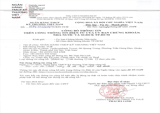

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
/usr/local/lib/python3.12/site-packages/transformers/utils/generic.py:965: FutureWarning: Both `num_logits_to_keep` and `logits_to_keep` are set for `DotsOCRForCausalLM.forward`. Using `logits_to_keep=1` and ignoring deprecated `num_logits_to_keep=None`.
  output = func(self, *args, **kwargs)


[
  {
    "bbox": [
      118,
      76,
      232,
      122
    ],
    "category": "Page-header",
    "text": "NGÂN"
  },
  {
    "bbox": [
      118,
      127,
      232,
      171
    ],
    "category": "Page-header",
    "text": "HÀNG"
  },
  {
    "bbox": [
      118,
      180,
      286,
      222
    ],
    "category": "Page-header",
    "text": "TMCP KỸ"
  },
  {
    "bbox": [
      118,
      237,
      286,
      277
    ],
    "category": "Page-header",
    "text": "THƯƠNG"
  },
  {
    "bbox": [
      118,
      288,
      200,
      333
    ],
    "category": "Page-header",
    "text": "VIỆT"
  },
  {
    "bbox": [
      118,
      344,
      211,
      383
    ],
    "category": "Page-header",
    "text": "NAM"
  },
  {
    "bbox": [
      294,
      94,
      464,
      125
    ],
    "category": "Page-header",
    "text": "Digitally signed"
  },
  {
    "bbox": [
      294,
      125,
      397,
      153
    ],
    "category": "Page-header",
    "text": "by NGÂN"
  

In [37]:
from IPython.display import display
#from PIL import Image

# !wget -qO /root/ocr-sample-image.jpg -q https://modal-cdn.com/ocr-sample-image.jpg

from pdf2image import convert_from_path
from PIL import Image
import os

# --- PDF TO IMAGE ---
pdf_path = "/root/TCB_2024_1_2_1.pdf"
output_dir = "/root/pdf_pages"
os.makedirs(output_dir, exist_ok=True)

print("Converting PDF pages to images...")
pages = convert_from_path(pdf_path)
for i, page in enumerate(pages, start=1):
    image_path = os.path.join(output_dir, f"page_{i}.jpg")
    page.save(image_path, "JPEG")
    print(f"✅ Saved: {image_path}")

print(f"Total pages converted: {len(pages)}")

# --- OCR PROMPT ---
print(dict_promptmode_to_prompt.keys())  # check available keys
prompt = dict_promptmode_to_prompt["prompt_layout_all_en"]  # general layout OCR prompt


# --- LOAD FIRST PAGE & DISPLAY ---
image_path = os.path.join(output_dir, "page_1.jpg")
im = Image.open(image_path)
display(im.resize((160, int(160 * im.width / im.height))))

# --- RUN OCR INFERENCE ---
result = inference(image_path, prompt, model, processor)
print(json.dumps(result, indent=2, ensure_ascii=False))

In [38]:
from PIL import Image, ImageDraw, ImageFont

CATEGORY_COLORS = {
    "Title": (26, 188, 156),
    "Section-header": (52, 152, 219),
    "Text": (46, 204, 113),
    "List-item": (39, 174, 96),
    "Caption": (241, 196, 15),
    "Footnote": (243, 156, 18),
    "Formula": (231, 76, 60),
    "Table": (142, 68, 173),
    "Picture": (127, 140, 141),
    "Page-header": (52, 73, 94),
    "Page-footer": (127, 0, 255),
}


def draw_bboxes_from_layout(img, layout_obj, show_labels=True, box_width=3, fill_alpha=60):
    """Draw semi-transparent fills + outlines for each element."""
    image = img.convert("RGBA")
    overlay = Image.new("RGBA", image.size, (0, 0, 0, 0))
    draw_overlay = ImageDraw.Draw(overlay)
    draw_outline = ImageDraw.Draw(image)
    font = ImageFont.truetype("DejaVuSans.ttf", size=20)

    for el in layout_obj:
        x1, y1, x2, y2 = el["bbox"]
        cat = el["category"]
        color = CATEGORY_COLORS.get(cat, (241, 196, 15))
        fill = (*color, fill_alpha)

        draw_overlay.rectangle([x1, y1, x2, y2], fill=fill)
        draw_outline.rectangle([x1, y1, x2, y2], outline=color, width=box_width)

        label = cat + (f": {el['text']}" if el.get("text") else "")
        print(label)
        try:
            tw, th = font.getbbox(label)[2:]
        except Exception:
            tw, th = font.getsize(label)
        pad = 4
        bg_rect = [x1, max(0, y1 - th - 2 * pad), x1 + tw + 2 * pad, y1]
        draw_overlay.rectangle(bg_rect, fill=(*color, 200))
        draw_overlay.text((x1 + pad, bg_rect[1] + pad), label, fill=(255, 255, 255, 255), font=font)

    return Image.alpha_composite(image, overlay)


def full_inference_demo(image_path):
    """Run full OCR inference and return the result."""
    from io import BytesIO

    from IPython import display

    img = Image.open(image_path)
    prompt = dict_promptmode_to_prompt["prompt_layout_all_en"]
    result = inference(image_path, prompt, model, processor)
    new_image = draw_bboxes_from_layout(img, result)

    # Export image as JPEG bytes, then display using display.Image()
    buffer = BytesIO()
    new_image.convert("RGB").save(buffer, format="JPEG")
    display.display(display.Image(buffer.getvalue()))

Processing page 1...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Completed OCR for page 1


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Page-header: NGÂN
Page-header: HÀNG
Page-header: TMCP KỸ
Page-header: THƯƠNG
Page-header: VIỆT
Page-header: NAM
Page-header: Digitally signed
Page-header: by NGÂN
Page-header: HÀNG TMCP KỸ
Page-header: THƯƠNG VIỆT
Page-header: NAM
Page-header: Date:
Page-header: 2024.07.22
Page-header: 09:49:18
Page-header: Mâu CBTT/SGDHCM-02
Page-header: +07'00' Ban hành kèm theo Quyết định số 340/QĐ-SGDHCM ngày 19 tháng 08 năm 2016 của TGD SGDCK TPHCM về Quy chế Công bố thông tin tại SGDCK TPHCM)
Text: NGÂN HÀNG TMCP
KỸ THƯƠNG VIỆT NAM
Text: Số: 3374 - Q3.12024/TCKH-TCB
Text: CỘNG HOÀ XÃ HỘI CHỦ NGHĨA VIỆT NAM
Text: Độc lập - Tự do - Hạnh phúc
Hà Nội, ngày 22 tháng 07 năm 2024
Section-header: ## CÔNG BỐ THÔNG TIN
### TRÊN CÔNG THÔNG TIN ĐIỆN TỬ CỦA УЫ BAN CHỨNG KHOÁN NHÀ NƯỚC VÀ SGDCK TP.HCM
List-item: Kính gửi: - Ủy ban Chứng khoán Nhà nước
- Sở Giao dịch chứng khoán TP.HCM
List-item: - Tên tổ chức: NGÂN HÀNG TMCP KỸ THƯƠNG VIỆT NAM
List-item: - Mã chứng khoán: TCB
List-item: - Địa chỉ trụ sở chính:

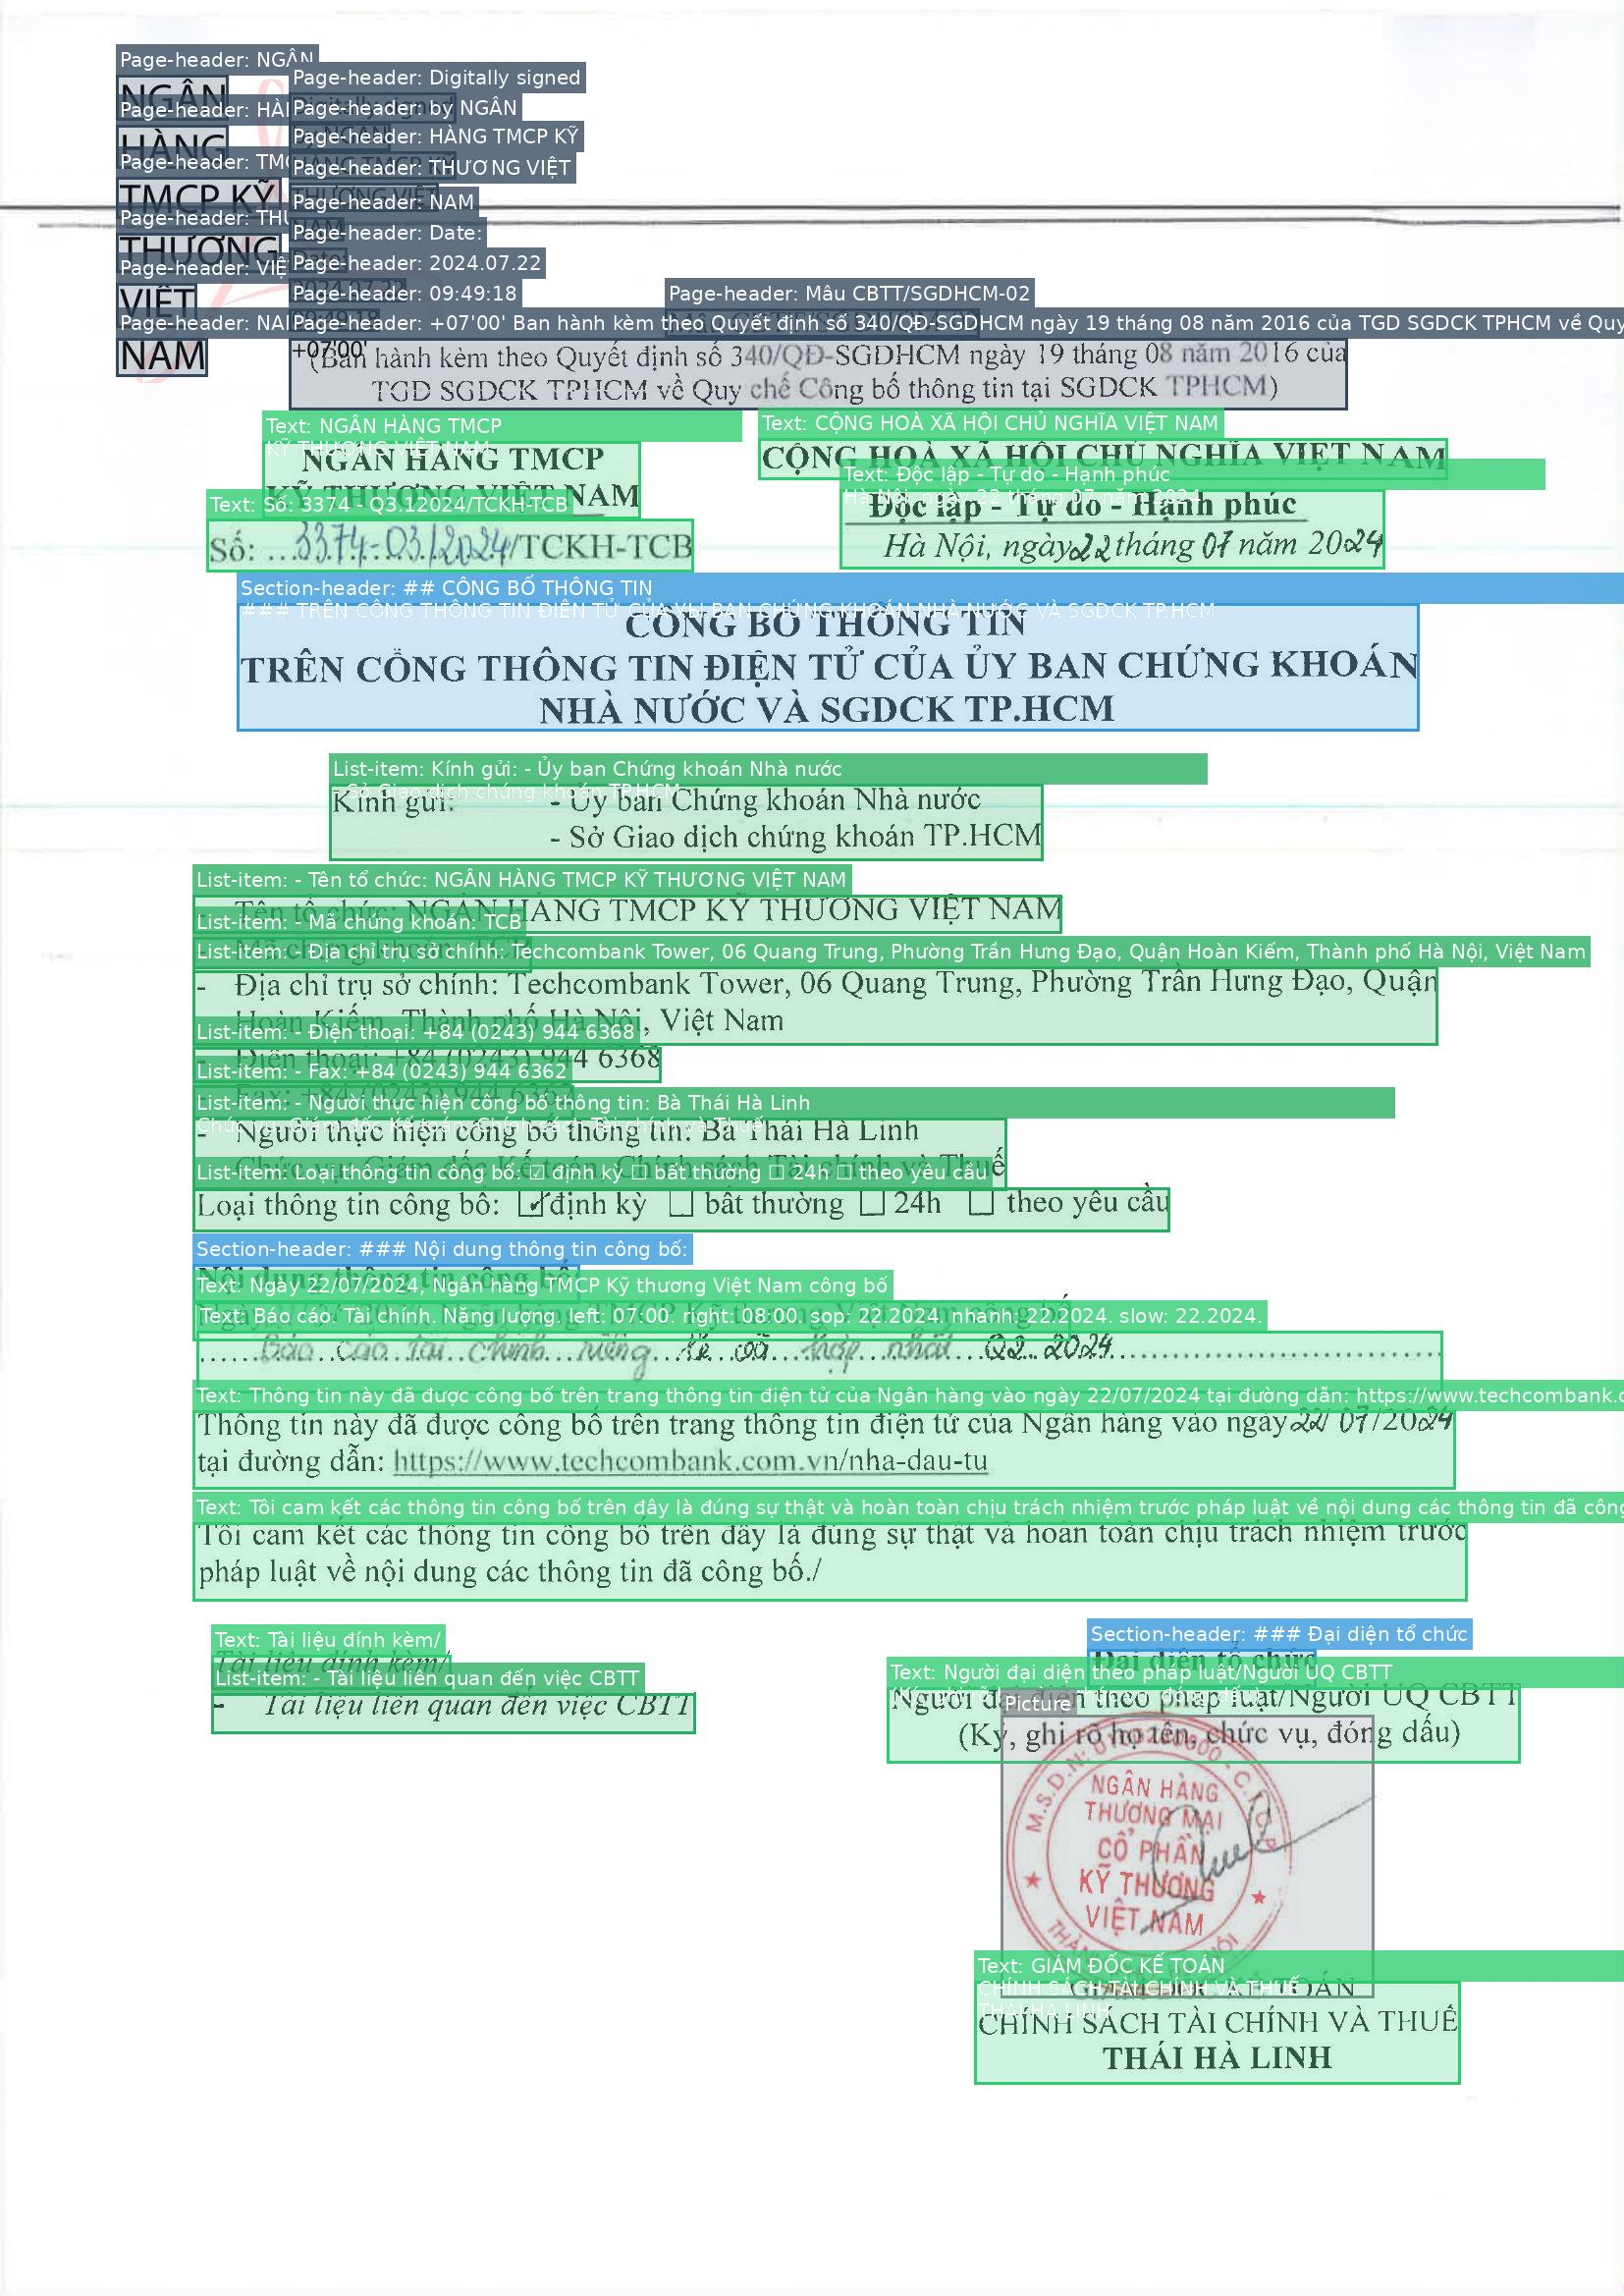

Processing page 2...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Completed OCR for page 2


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Section-header: Ngân hàng Thương mại Cổ phần Kỹ thương
Việt Nam
Text: Báo cáo tài chính hợp nhất
Text: Cho giai đoạn từ ngày 1 tháng 1 năm 2024 đến ngày 30 tháng 6 năm 2024
Picture


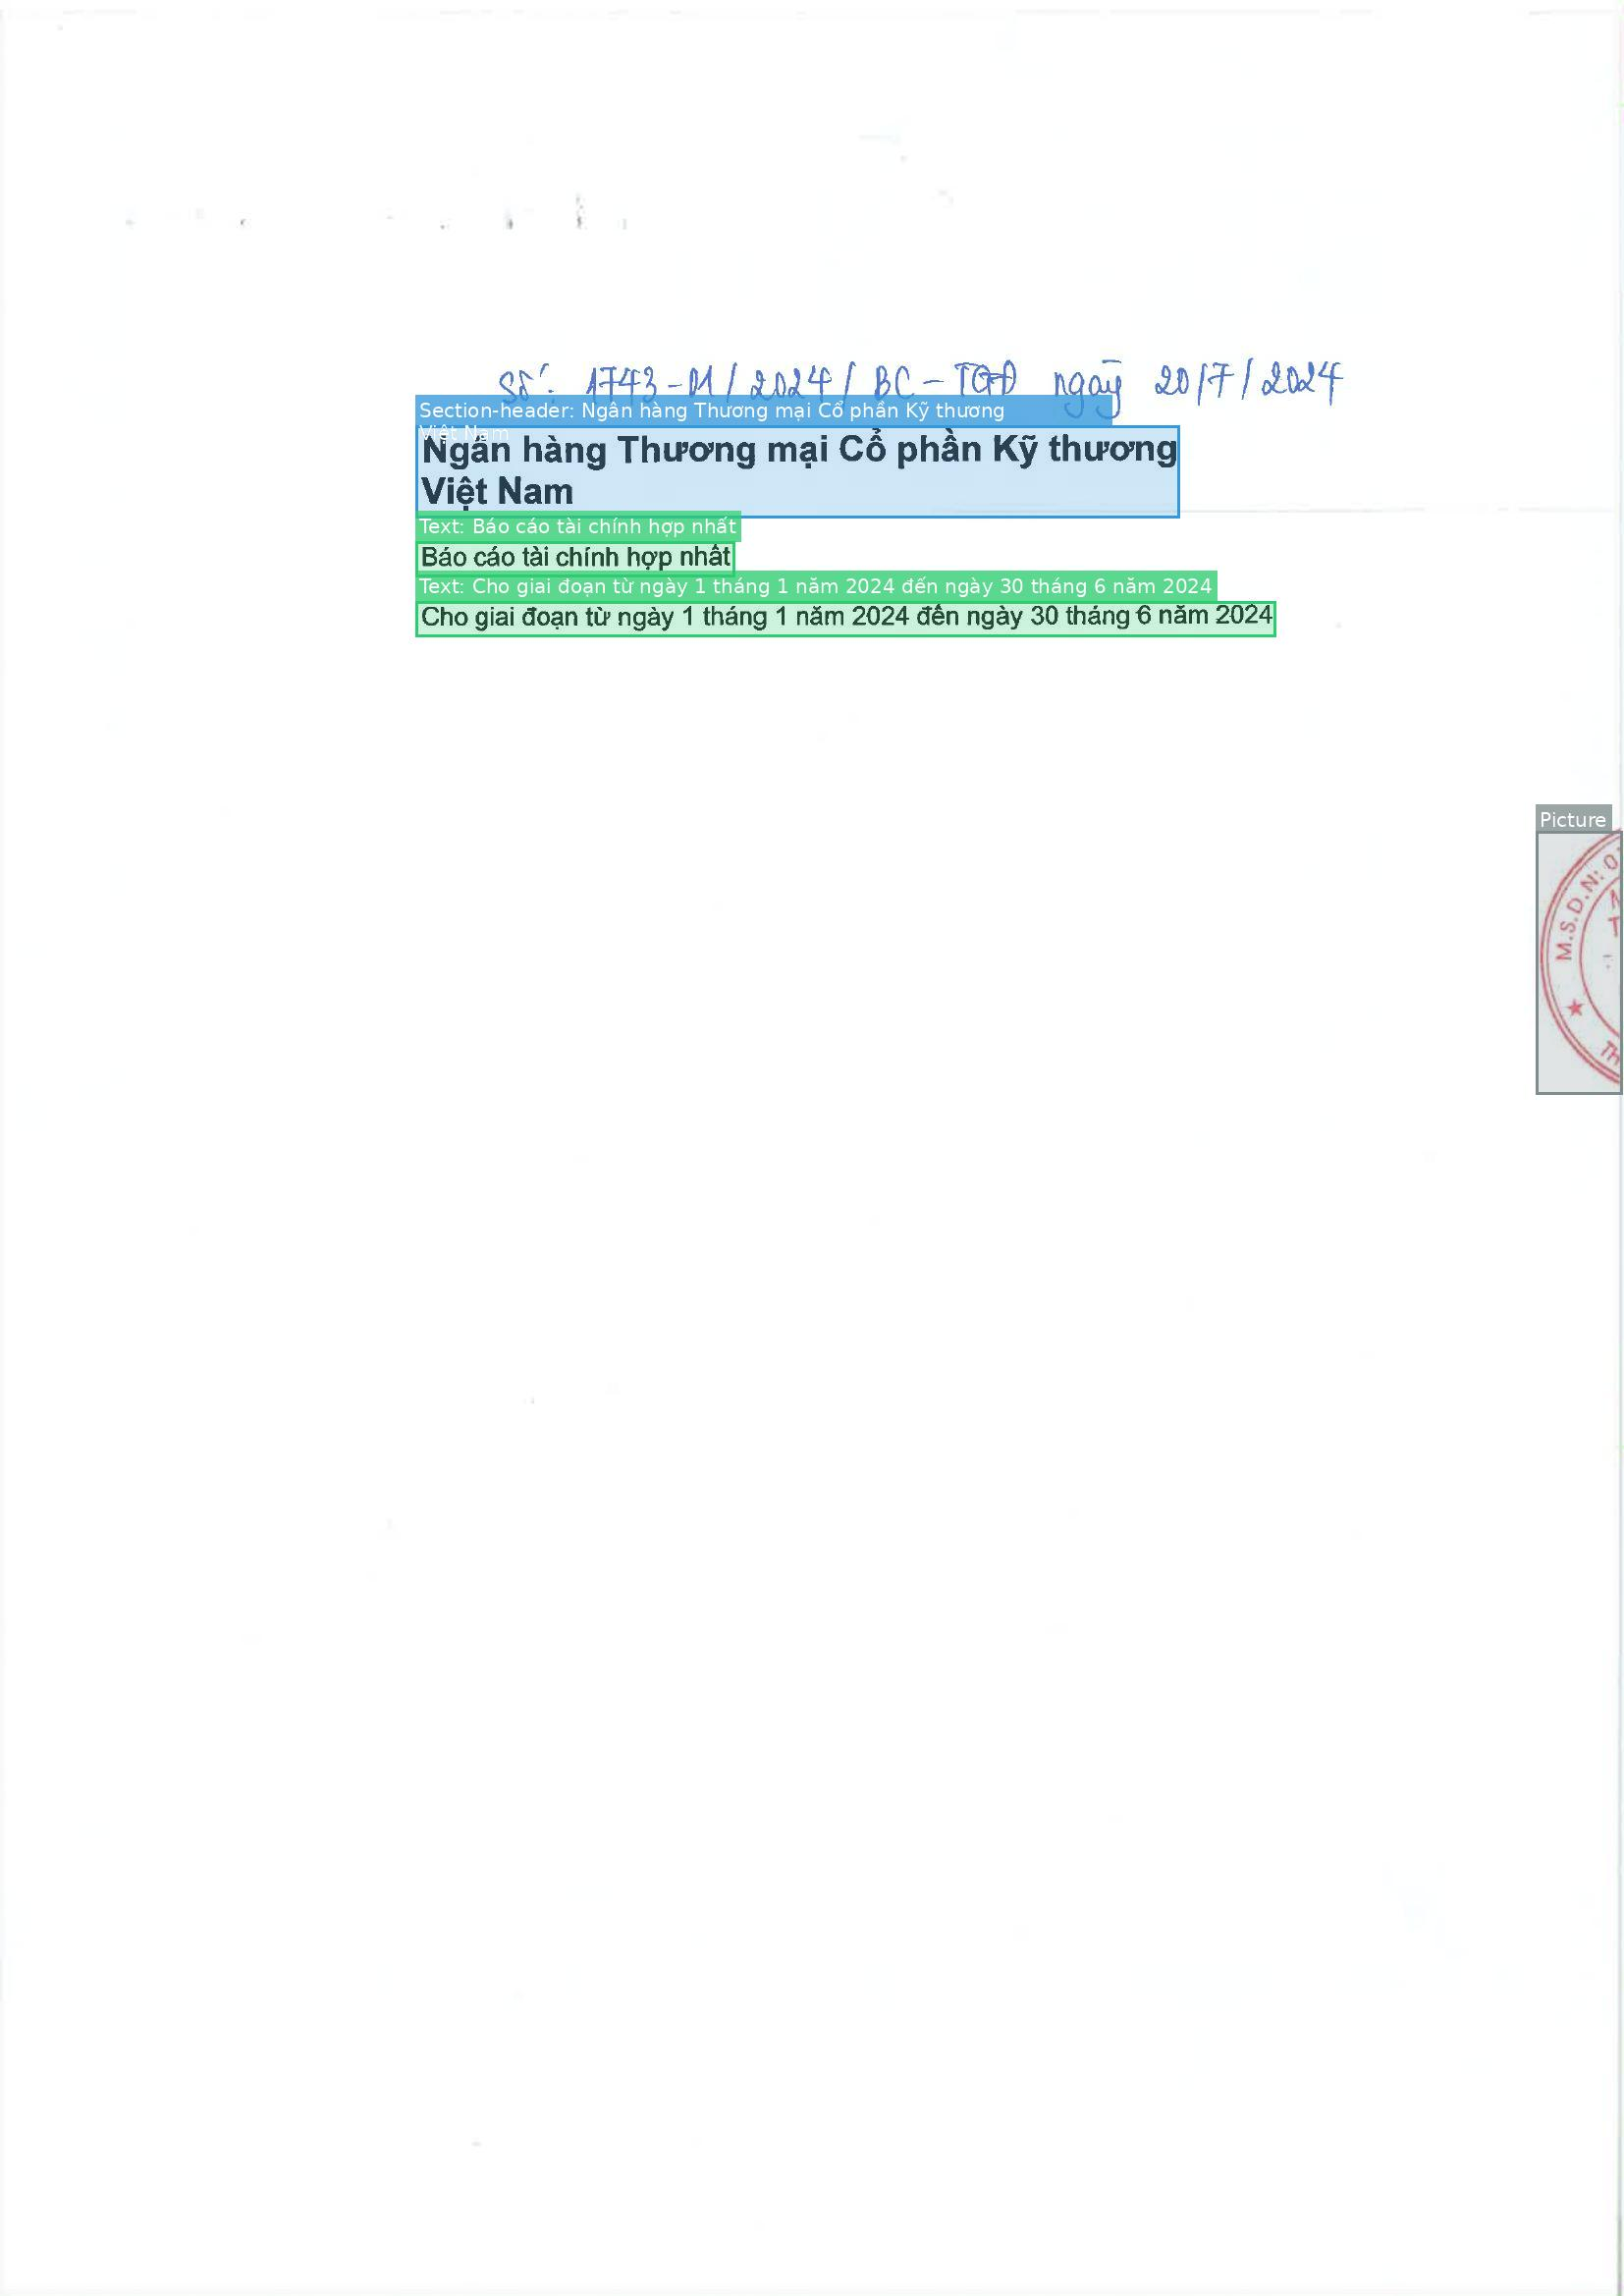

Processing page 3...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Completed OCR for page 3


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Page-header: Ngân hàng TMCP Kỹ thương Việt Nam
Section-header: MỤC LỤC
Table: <table><thead><tr><td></td><td>Trang</td></tr></thead><tbody><tr><td>Thông tin chung</td><td>1 - 2</td></tr><tr><td>Báo cáo tình hình tài chính hợp nhất</td><td>3 - 5</td></tr><tr><td>Báo cáo kết quả hoạt động hợp nhất</td><td>6</td></tr><tr><td>Báo cáo lưu chuyển tiền tệ hợp nhất</td><td>7 - 8</td></tr><tr><td>Thuyết minh báo cáo tài chính hợp nhất</td><td>9 - 73</td></tr></tbody></table>
Picture


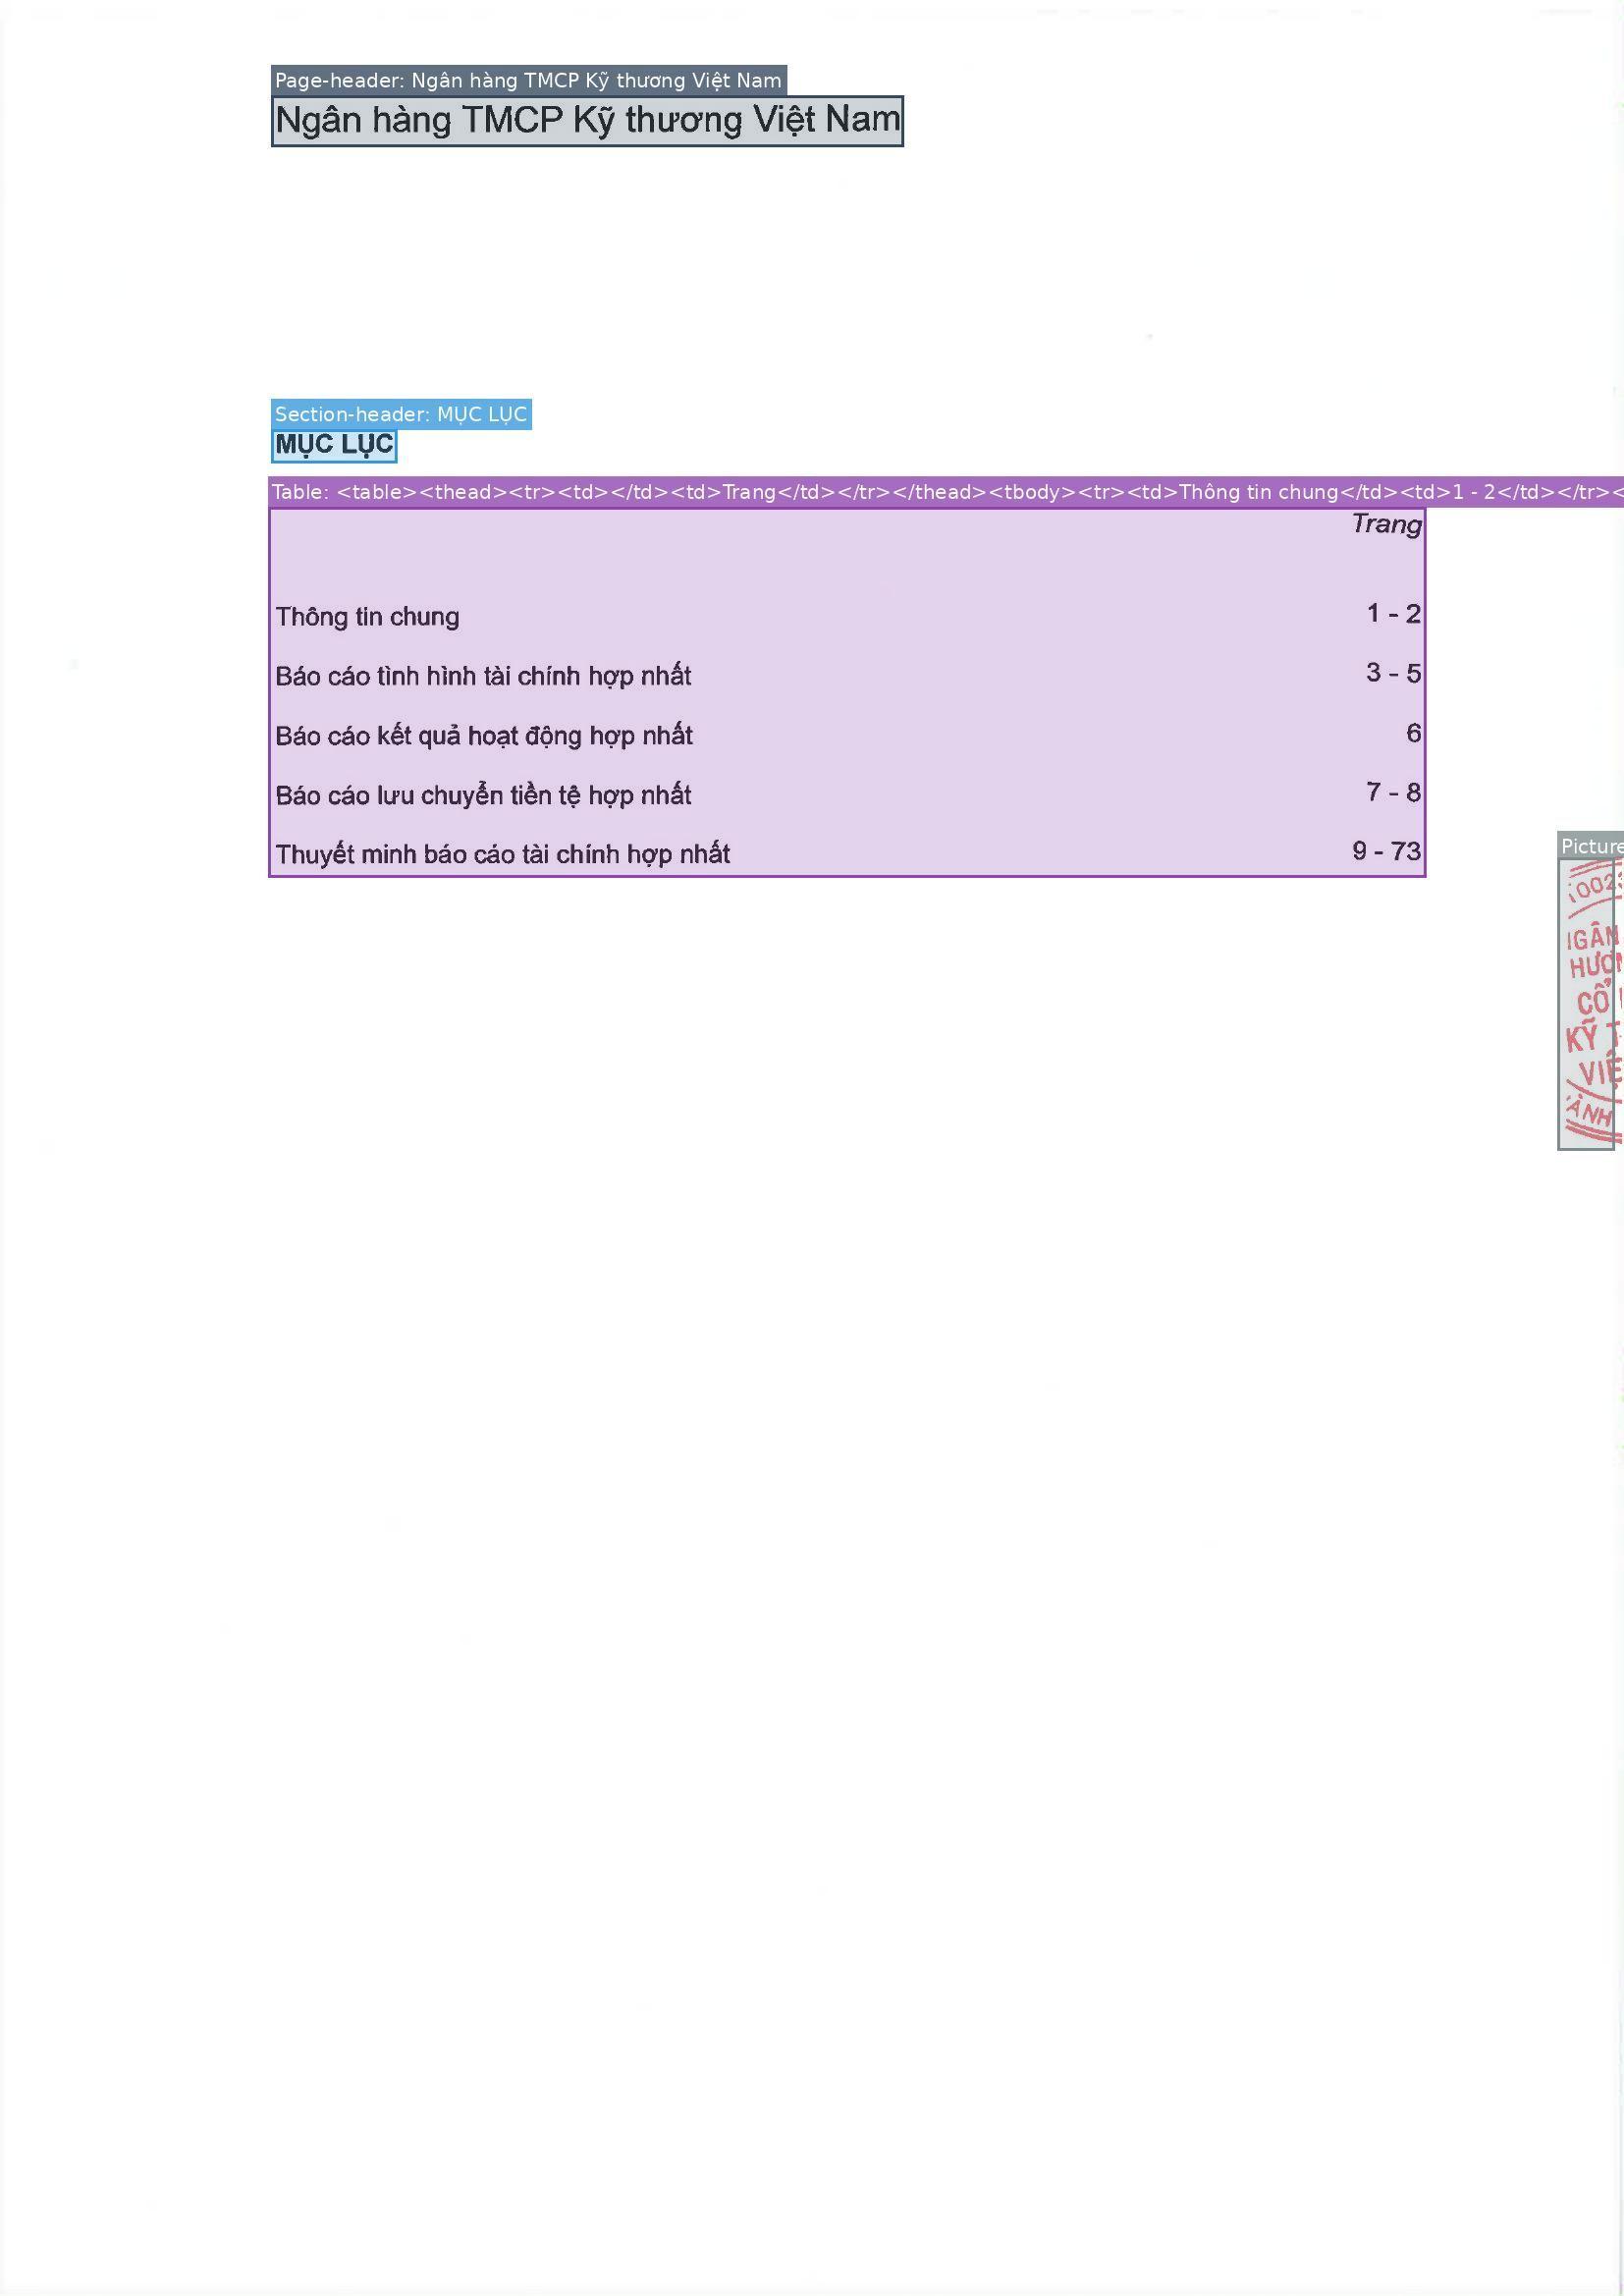

Processing page 4...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Completed OCR for page 4


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Section-header: # Ngân hàng TMCP Kỹ thương Việt Nam
Text: ## THÔNG TIN CHUNG
Section-header: ### NGÂN HÀNG
Text: Ngân hàng Thương mại Cổ phần Kỹ thương Việt Nam (sau đây gọi tắt là "Ngân hàng") là một ngân hàng thương mại cổ phần được thành lập và đăng ký tại nước Cộng hòa Xã hội Chủ nghĩa Việt Nam.
Text: Ngân hàng hoạt động theo Giấy phép hoạt động Ngân hàng số 0038/GP-NHNN do Ngân hàng Nhà nước Việt Nam ("NHNN") cấp ngày 6 tháng 3 năm 2018 (cấp đổi lại cho Giấy phép hoạt động số 0040/NH-GP cấp ngày 6 tháng 8 năm 1993) và Giấy chứng nhận Đăng ký kinh doanh số 0100230800 do Sở Kế hoạch và Đầu tư Hà Nội cấp ngày 3 tháng 1 năm 2024. Thời gian hoạt động của Ngân hàng là 99 năm kể từ ngày 6 tháng 8 năm 1993.
Text: Các hoạt động chính của Ngân hàng bao gồm huy động và nhận tiền gửi ngắn, trung và dài hạn từ các tổ chức và cá nhân; cung cấp tín dụng ngắn, trung và dài hạn dựa trên tính chất và khả năng cung ứng nguồn vốn của Ngân hàng; thực hiện các nghiệp vụ thanh toán và ngân quỹ và các dị

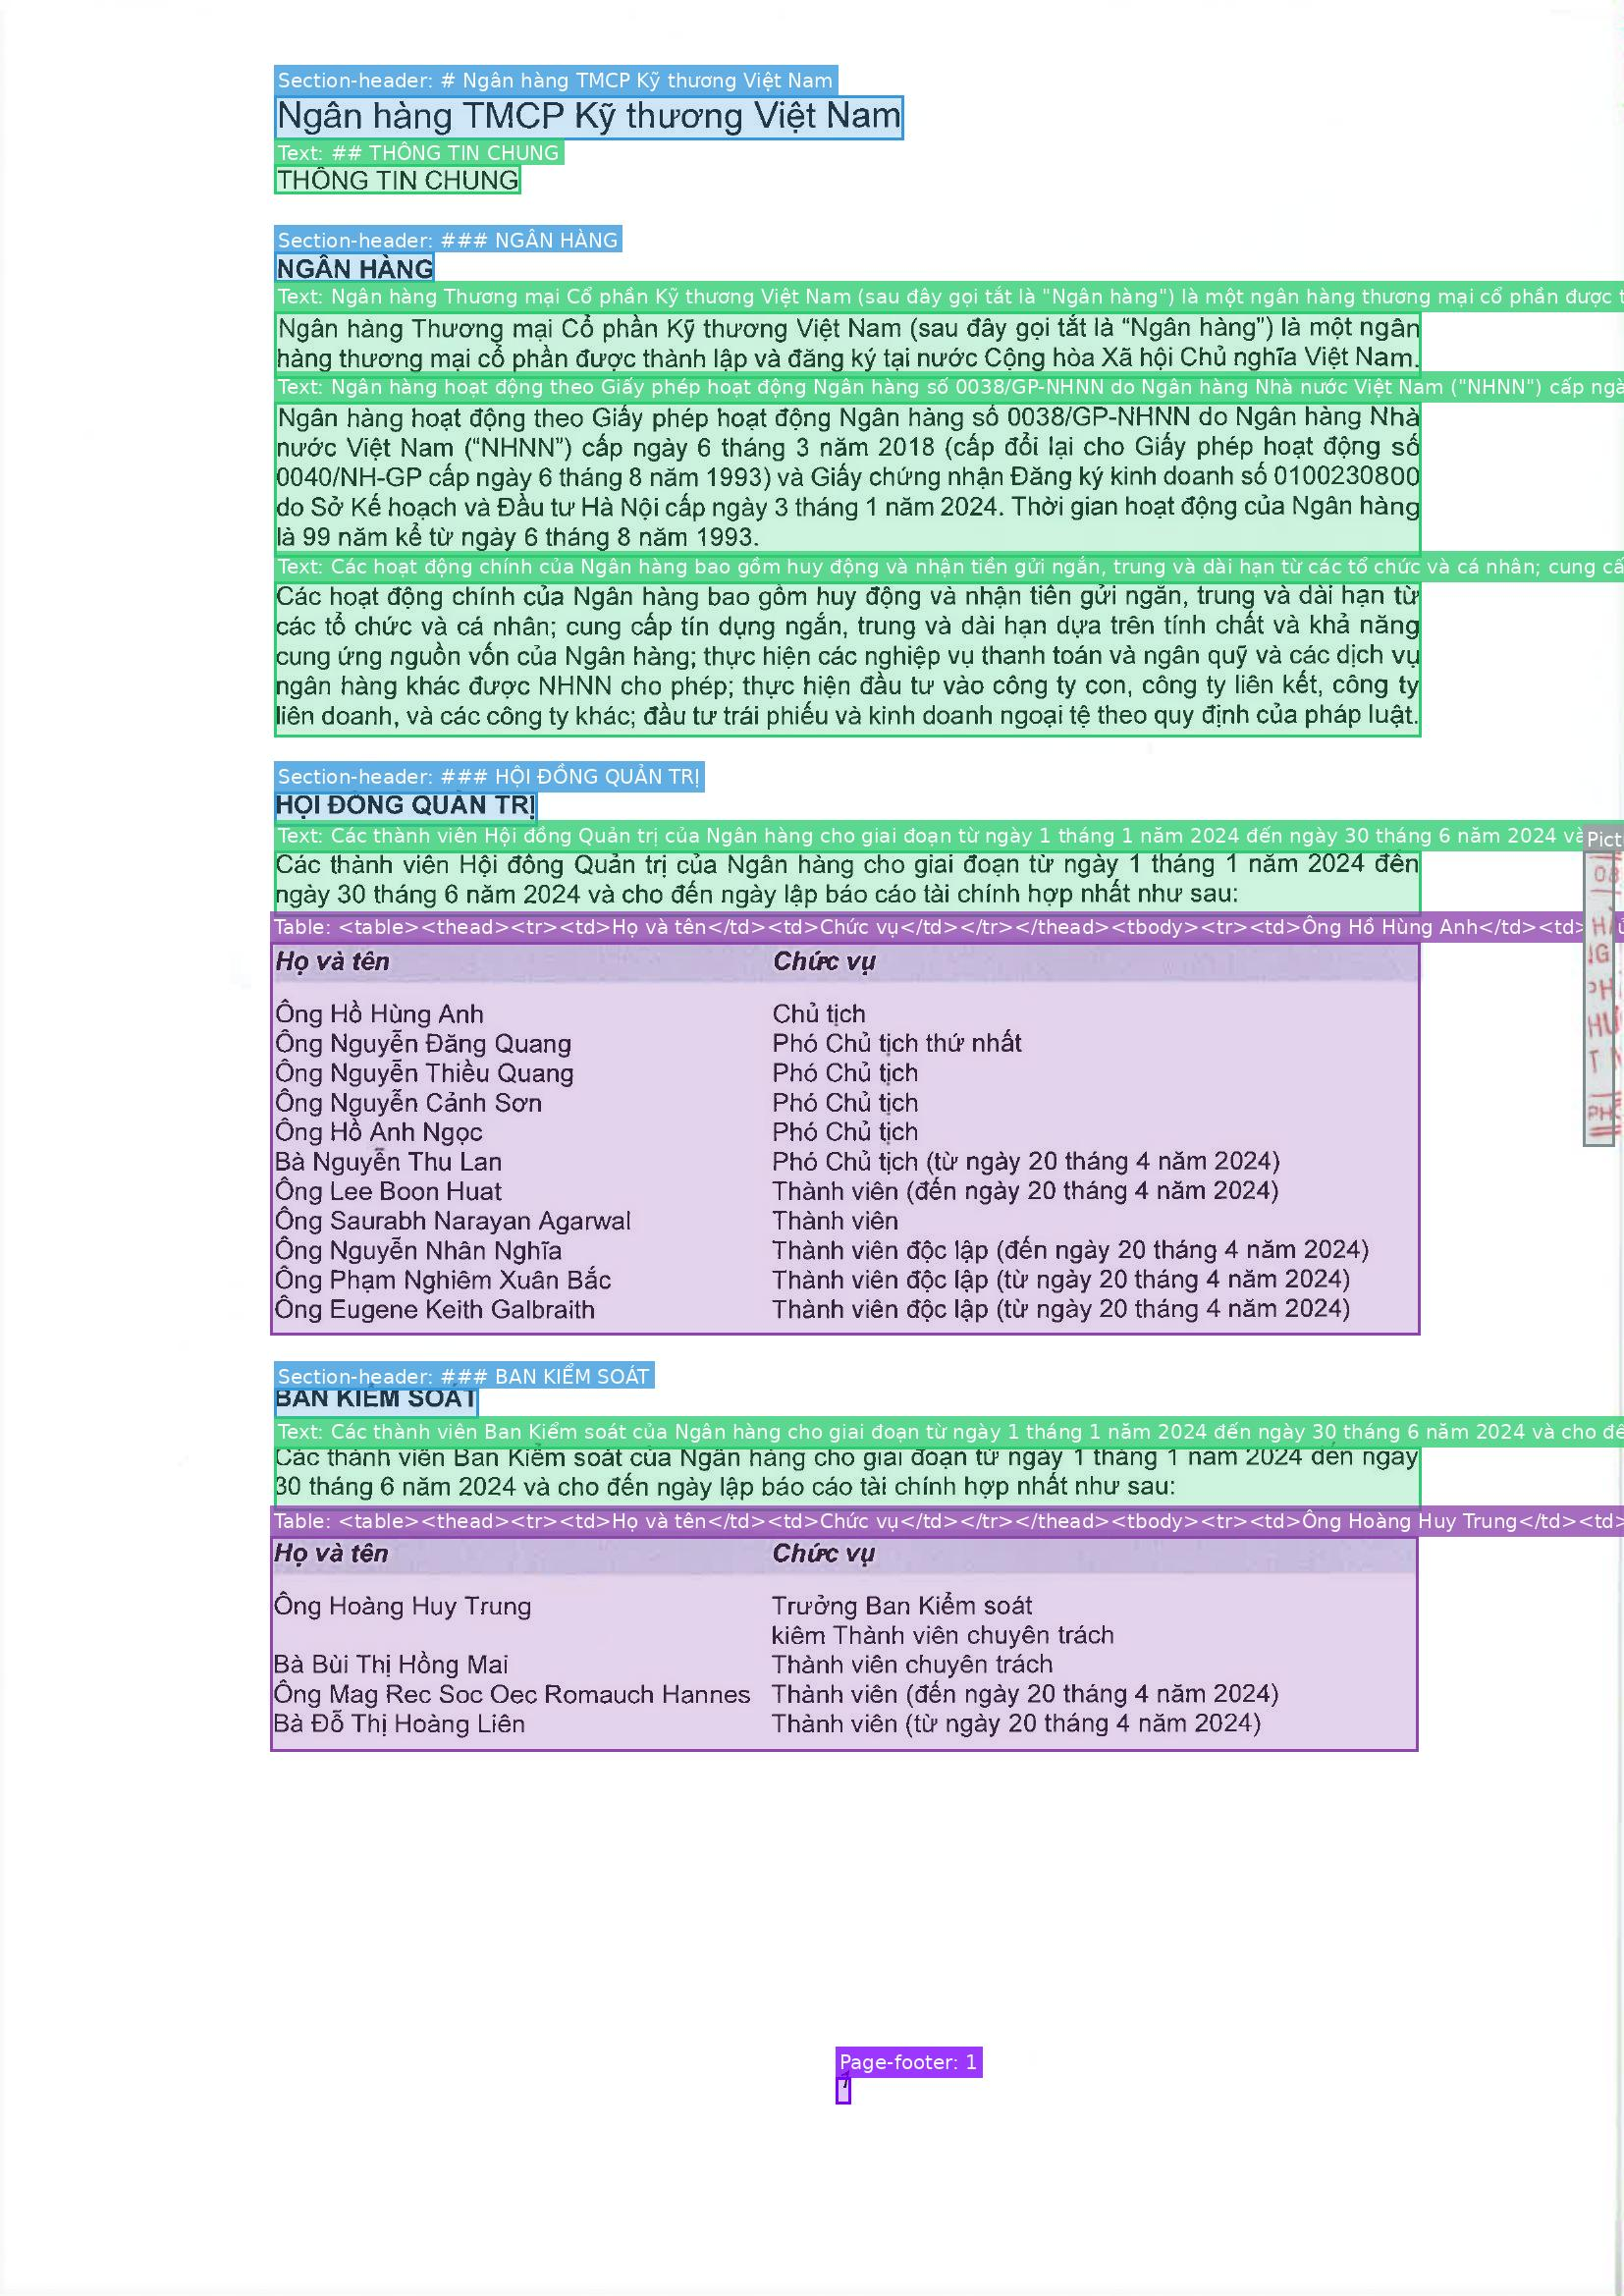

Processing page 5...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Completed OCR for page 5


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Section-header: # Ngân hàng TMCP Kỹ thương Việt Nam
Text: ## THÔNG TIN CHUNG (tiếp theo)
Section-header: ### BAN LÃNH ĐẠO
Text: Các thành viên Ban Lãnh đạo của Ngân hàng cho giai đoạn từ ngày 1 tháng 1 năm 2024 đến ngày 30 tháng 6 năm 2024 và cho đến ngày lập báo cáo tài chính hợp nhất như sau:
Table: <table><thead><tr><td>Họ và tên</td><td>Chức vụ</td></tr></thead><tbody><tr><td>Ông Jens Lottner</td><td>Tổng Giám đốc</td></tr><tr><td>Ông Phùng Quang Hưng</td><td>Phó Tổng Giám đốc thường trực<br/>kiêm Giám đốc Khối Ngân hàng doanh nghiệp<br/>và Định chế Tài chính (từ ngày 1 tháng 1 năm 2024)</td></tr><tr><td>Ông Phạm Quang Thắng</td><td>Phó Tổng Giám đốc<br/>kiêm Giám đốc Khối Quản trị Ngân hàng</td></tr><tr><td>Ông Phan Thanh Sơn</td><td>Phó Tổng Giám đốc<br/>kiêm Giám đốc Khối Ngân hàng Giao dịch toàn cầu</td></tr><tr><td>Bà Nguyễn Thu Lan</td><td>Quyền Giám đốc Khối Quản trị rủi ro<br/>(đến ngày 30 tháng 6 năm 2024)</td></tr><tr><td>Bà Lê Hồng Hạnh</td><td>Quyền Giám đốc Khối Quản t

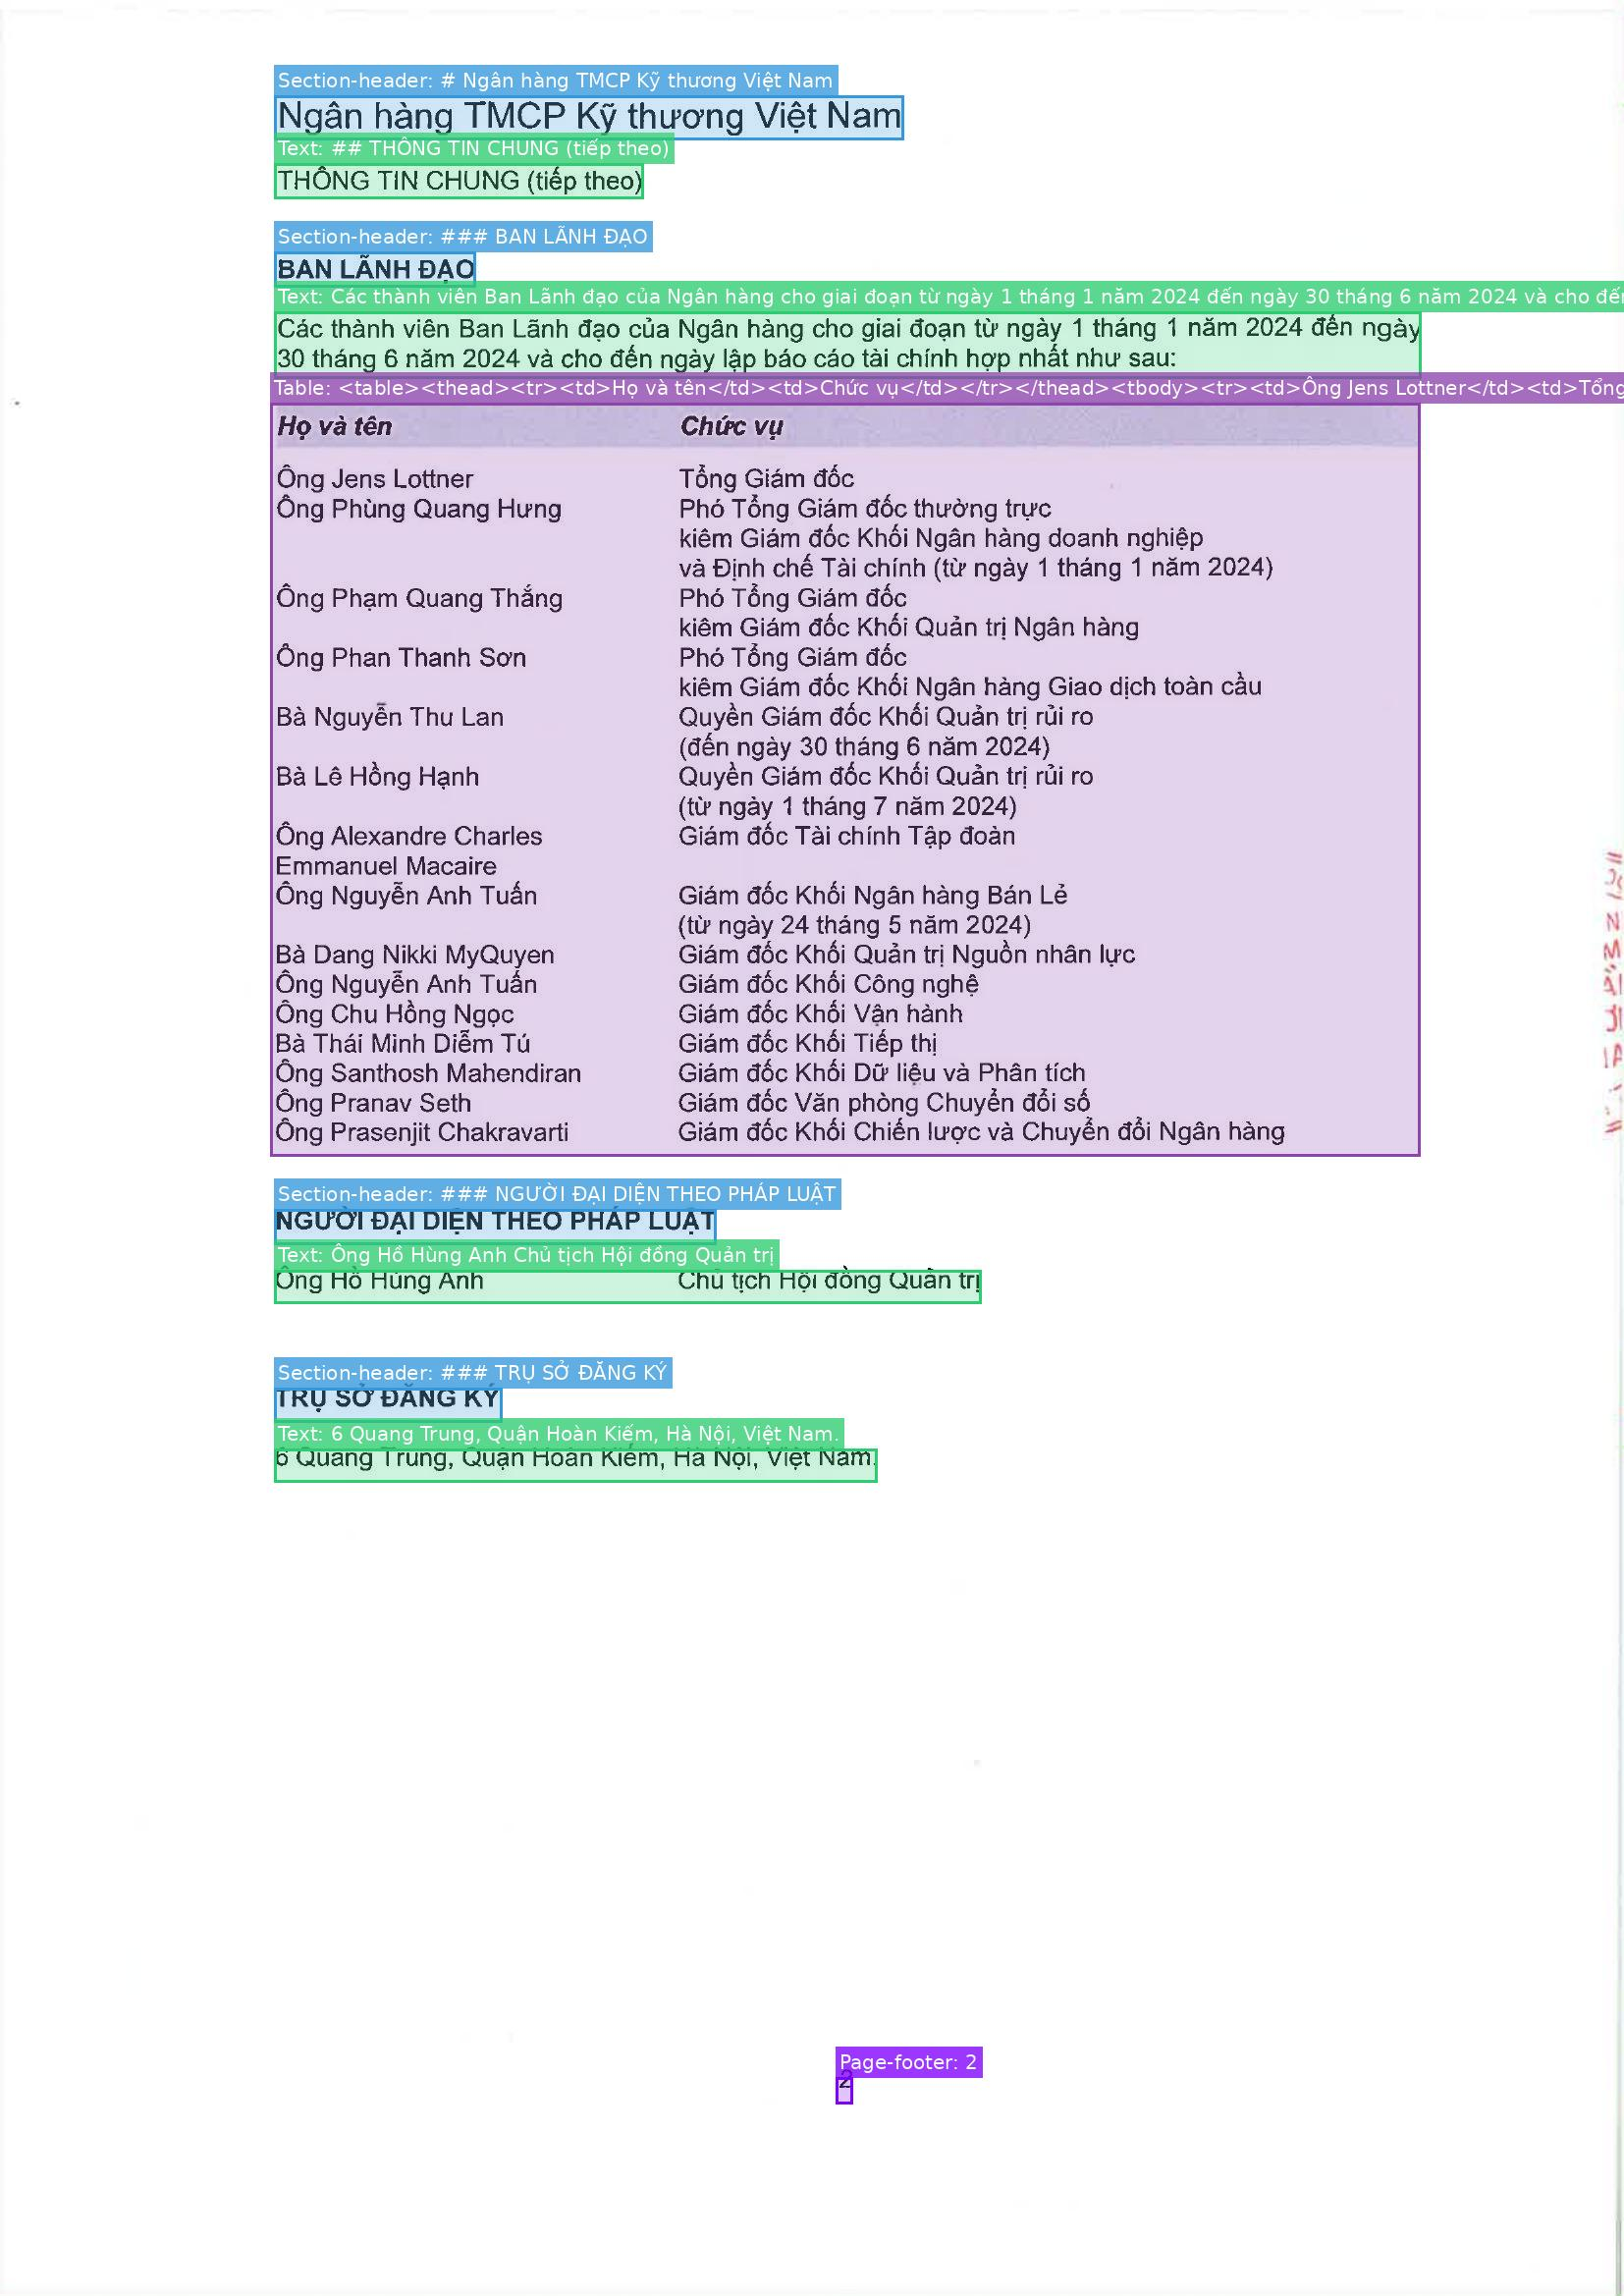

Processing page 6...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


KeyboardInterrupt: 

In [41]:
for i in range(1, len(pages) + 1):
    image_path = os.path.join(output_dir, f"page_{i}.jpg")
    print(f"Processing page {i}...")
    result = inference(image_path, prompt, model, processor)
    print(f"✅ Completed OCR for page {i}")
    # Optionally save results to file
    with open(os.path.join(output_dir, f"page_{i}_ocr.json"), "w", encoding="utf-8") as f:
        json.dump(result, f, indent=2, ensure_ascii=False), f"page_{i}.jpg"
    full_inference_demo(image_path)




Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Page-header: Deuxième Année. — Numéro 87
Page-header: Cinq Centimes
Picture
Page-header: JEUDI 13 JANVIER 1908
Text: Directeur
Text: ERNEST VAUGHAN
Section-header: ABONNEMENTS
Table: <table><thead><tr><th></th><th>Un an</th><th>Six mois</th><th>Trois mois</th></tr></thead><tbody><tr><td>PARIS</td><td>20</td><td>10</td><td>5</td></tr><tr><td>DÉPARTEMENTS ET ALGÉRIE</td><td>24</td><td>12</td><td>6</td></tr><tr><td>ÉTRANGER (UNION POSTALE)</td><td>35</td><td>18</td><td>10</td></tr></tbody></table>
Section-header: POUR LA RÉDACTION :
Text: S'adresser à M. A. BERTHIER
Text: Secrétaire de la Rédaction
Text: ADRESSE TÉLÉGRAPHIQUE : AURORE-PARIS
Title: L'AURORE
Text: Littéraire, Artistique, Sociale
Text: Directeur
Text: ERNEST VAUGHAN
Section-header: LES ANNONCES SONT REÇUES :
Text: 142 — Rue Montmartre — 142
Text: AUX BUREAUX DU JOURNAL
Text: Les manuscrits non insérés ne sont pas rendus
Text: ADRESSER LETTRES ET MANDATS à
Text: M. A. BOUIT, Administrateur
Text: Téléphone : 102-33
Text: J'Acc

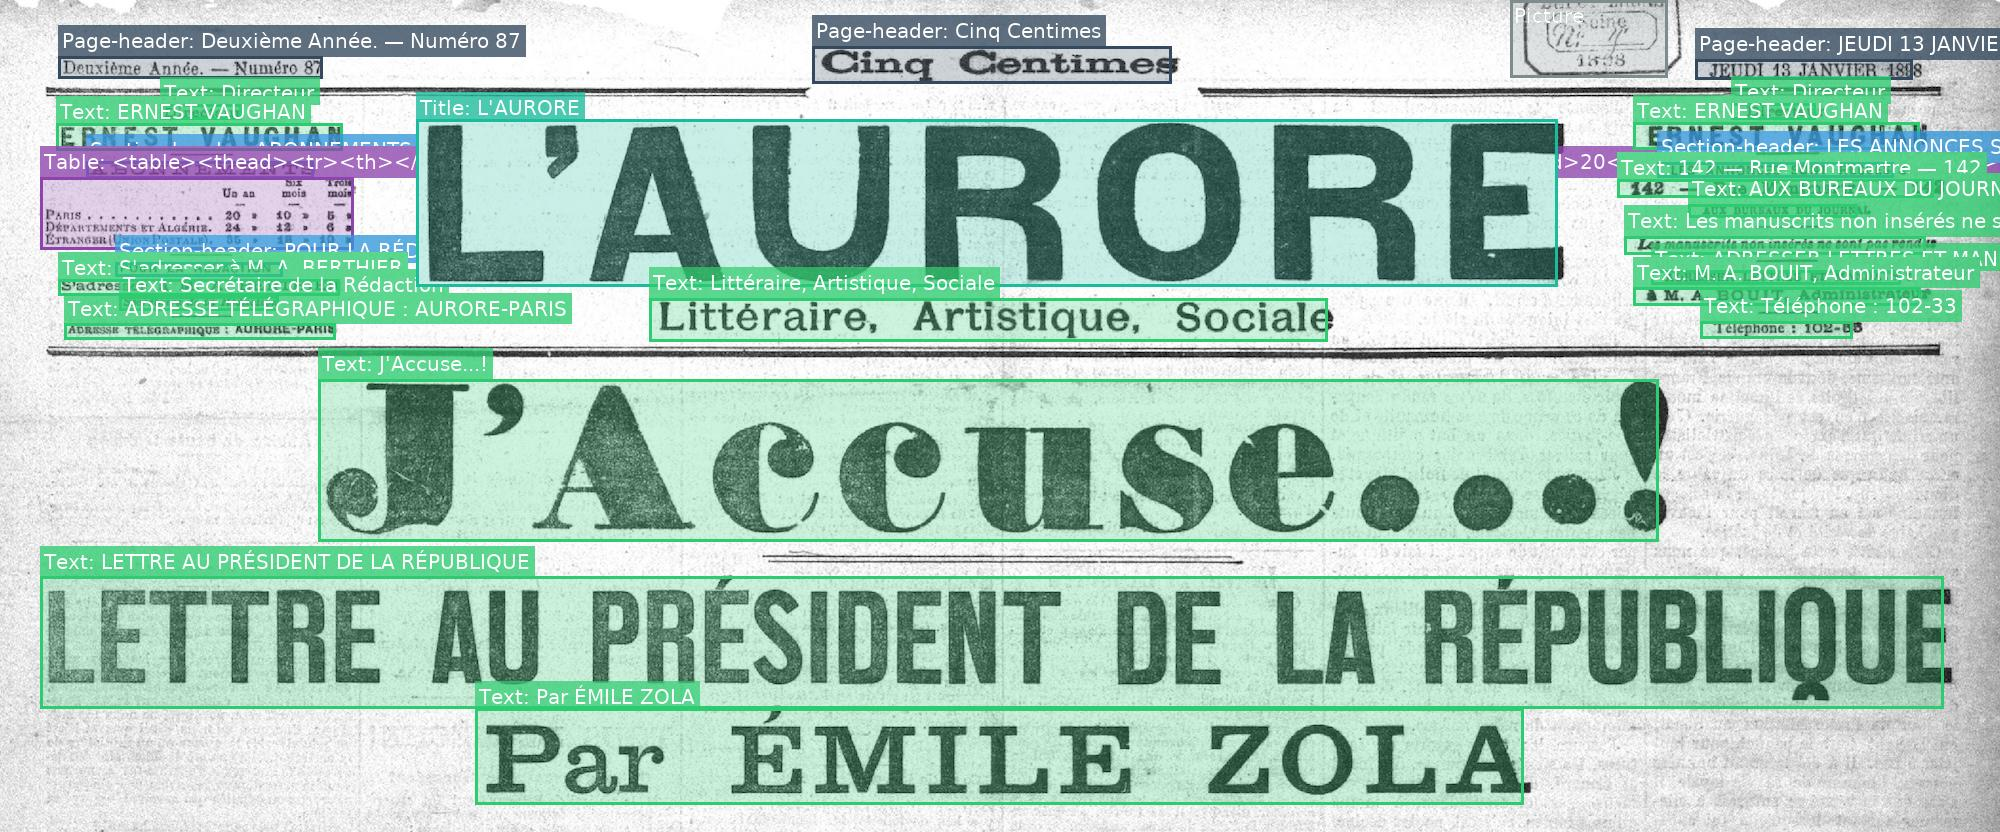

In [35]:
!wget -qO jaccuse.jpg https://modal-cdn.com/jaccuse.jpg
image_path = "/root/jaccuse.jpg"
full_inference_demo(image_path)

In [ ]:
prompt = dict_promptmode_to_prompt["prompt_ocr"]  # ✅ Markdown-style text

for i in range(1, len(pages) + 1):
    image_path = os.path.join(output_dir, f"page_{i}.jpg")
    print(f"Processing page {i}...")

    result = inference(image_path, prompt, model, processor)
    print(f"✅ Completed OCR for page {i}")

    # --- Save as Markdown file ---
    markdown_text = result if isinstance(result, str) else json.dumps(result, indent=2, ensure_ascii=False)
    with open(os.path.join(output_dir, f"page_{i}_ocr.md"), "w", encoding="utf-8") as f:
        f.write(markdown_text)
    print(f"💾 Saved OCR result to page_{i}_ocr.md")

print(f"\n🎉 All {len(pages)} pages processed successfully!")
print(f"Results saved in: {output_dir}")


Processing page 1...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


✅ Completed OCR for page 1
💾 Saved OCR result to page_1_ocr.md
Processing page 2...


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


That's it. Pretty cool that OCR models can produce such structured,
precise output!

In the file browser on the left side of the notebook UI, you can try
using a different image and running the OCR again. Just drag–and-drop
your file to upload. You can also extend this to dataset preparation or
deploy it as a serverless API on Modal in the future.

